In [ ]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import SolveLinSys
from utilities import compute_derivatives

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} - \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [199]:
def false_transient_one_iteration(stateSpace, A, B_b, B_z, C_bb, C_zz, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_b.reshape(-1, 1, order='F'), B_z.reshape(-1, 1, order='F')])
    C = np.hstack([C_bb.reshape(-1, 1, order='F'), C_zz.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (z_mat, b_mat) = np.meshgrid(z_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])

    if v0 is None:
#         v0 = δ*η*b_mat
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        e = b_mat*δ*η / (b_mat*τ*z_mat + ℓ)
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)

        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        D = b_mat*(δ*η*np.log(e) - τ*z_mat*e + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

#         print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [200]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

In [201]:
# Grid setting
n_z = 20
z_min = 1e-6
z_max = 2
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 100
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

In [202]:
log_ell_grid = np.linspace(-13, -5, 100)
ℓ_step = 1e-7

In [203]:
ψs = []
es = []
ψs_next = []
es_next = []

# ψ_guess, _ = false_transient(z_grid, b_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2000)

for i, ℓ in enumerate(np.exp(log_ell_grid)):
    print(i)
    max_iter = 1000
    ψ, e = false_transient(z_grid, b_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψ_next, e_next = false_transient(z_grid, b_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψs.append(ψ)
    es.append(e)
    ψs_next.append(ψ_next)
    es_next.append(e_next)

0
Iteration 1000: LHS Error: 3.69276168451756e-06; RHS Error 9.800479283823718e-05
Iteration 1000: LHS Error: 3.7193366902578233e-06; RHS Error 9.482559436526478e-05
1
Iteration 1000: LHS Error: 3.7417788204979242e-06; RHS Error 9.212554306400466e-05
Iteration 1000: LHS Error: 3.7651073536604414e-06; RHS Error 8.930382006293422e-05
2
Iteration 1000: LHS Error: 3.788284581937671e-06; RHS Error 8.648517507387572e-05
Iteration 1000: LHS Error: 3.8087282888143482e-06; RHS Error 8.398637402624702e-05
3
Iteration 1000: LHS Error: 3.8323405740611945e-06; RHS Error 8.108568130811079e-05
Iteration 1000: LHS Error: 3.8502280759358624e-06; RHS Error 7.887794622183253e-05
4
Iteration 1000: LHS Error: 3.874017355869411e-06; RHS Error 7.592825624457965e-05
Iteration 1000: LHS Error: 3.889645286358611e-06; RHS Error 7.398227809587033e-05
5
Iteration 1000: LHS Error: 3.913392015502445e-06; RHS Error 7.101327309240295e-05
Iteration 1000: LHS Error: 3.927027241253881e-06; RHS Error 6.930214235463506e-05

Iteration 1000: LHS Error: 1.1440266211956707e-05; RHS Error 1.3073982727043354e-05
Iteration 1000: LHS Error: 1.1442115526255625e-05; RHS Error 1.3075386604581908e-05
50
Iteration 1000: LHS Error: 1.1617465730542897e-05; RHS Error 1.3212221835394683e-05
Iteration 1000: LHS Error: 1.1619171619445257e-05; RHS Error 1.3213587401883096e-05
51
Iteration 1000: LHS Error: 1.1794673120638088e-05; RHS Error 1.3357273570271675e-05
Iteration 1000: LHS Error: 1.1796246697337587e-05; RHS Error 1.3358589070121217e-05
52
Iteration 1000: LHS Error: 1.1971887640252477e-05; RHS Error 1.3508159927929197e-05
Iteration 1000: LHS Error: 1.1973339158907748e-05; RHS Error 1.3509417419724595e-05
53
Iteration 1000: LHS Error: 1.214910878283293e-05; RHS Error 1.3664023971258284e-05
Iteration 1000: LHS Error: 1.2150447694703193e-05; RHS Error 1.3665218481785356e-05
54
Iteration 1000: LHS Error: 1.2326335976795e-05; RHS Error 1.3824117047327134e-05
Iteration 1000: LHS Error: 1.2327571030326667e-05; RHS Error 1.38

Iteration 1000: LHS Error: 1.9949438648581008e-05; RHS Error 2.143275657956619e-05
98
Iteration 1000: LHS Error: 2.0126698566658163e-05; RHS Error 2.1609734781283902e-05
Iteration 1000: LHS Error: 2.0126733869862967e-05; RHS Error 2.1609770024071974e-05
99
Iteration 1000: LHS Error: 2.0303996976833716e-05; RHS Error 2.1786706547019443e-05
Iteration 1000: LHS Error: 2.030402953928645e-05; RHS Error 2.1786739045884804e-05


In [204]:
ϕs = []
rs = []
ψs_new = []
for i in range(len(ψs)):
    ψ_b1_i = ψs[i][:, -1]
    ψ_b1_ip1 = ψs_next[i][:, -1]
    dψ = (ψ_b1_ip1-ψ_b1_i)/ℓ_step
    ψ = (ψ_b1_ip1+ψ_b1_i)/2.
    ℓ = np.exp(log_ell_grid)[i] + ℓ_step/2.
    r = -dψ
    ϕ = ψ + ℓ*r
    ψs_new.append(ψ)
    ϕs.append(ϕ)
    rs.append(r)

In [234]:
z_loc = 19
ϕ_z = np.array([ϕ[z_loc] for ϕ in ϕs])
r_z = np.array([r[z_loc] for r in rs])
sort_indices = np.argsort(r_z)
ϕ_z_sorted = ϕ_z[sort_indices]
r_z_sorted = r_z[sort_indices]

# Calculate dϕ/dr, e_star and Et
r_z, indices = np.unique(r_z_sorted, return_index=True)
ϕ_z = ϕ_z_sorted[indices]
ϕ_der = (ϕ_z[1:]-ϕ_z[:-1])/(r_z[1:]-r_z[:-1])
r_z = (r_z[1:]+r_z[:-1])/2
ϕ_z = (ϕ_z[1:]+ϕ_z[:-1])/2
e_z = δ*η/(τ*z_grid[z_loc]+ϕ_der)

In [235]:
def simulate_emission(e_grid, r_grid, r_start=1500, T=100):
    """
    Simulate emission trajectory baesd on grids of emission and reserve.

    Parameters
    ----------
    e_grid : (N, ) ndarray
        Grid of emission.
    r_grid : (N, ) ndarray
        Grid of reserve.

    Returns
    -------
    Et : (T, ) ndarray
        Emission trajectory.

    """
    Et = np.zeros(T)
    r_remain = r_start
    for i in range(T):
        loc = find_nearest_value(r_grid, r_remain)
        Et[i] = e_grid[loc]
        r_remain = r_remain - Et[i]
    return Et


def find_nearest_value(array, value):
    loc = np.abs(array - value).argmin()
    return loc

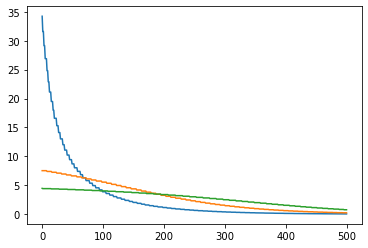

In [236]:
Et_19 = simulate_emission(e_z, r_z, r_start=1500, T=500)
plt.plot(Et_0)
plt.plot(Et_10)
plt.plot(Et_19)

In [259]:
# Simulation to compute quantile
# dZ = -ρ*(Z-μ_2)*dt + np.sqrt(Z)*σ_2*dW
def simulate(T=1_000_000):
    Ws = np.random.normal(size=T)
    Z = np.zeros(T)
    Z[0] = μ_2
    for i in range(1, T):
        Z[i] = Z[i-1] + (Z[i-1]-μ_2)*(-ρ) + np.sqrt(Z[i-1])*σ_2*Ws[i]
    return Z

In [260]:
Z = simulate(T=1_000_000)

In [266]:
# np.quantile(Z, 0.90)

1.3172478454208487

In [267]:
0.6994771371520058 # 10%, 7
0.9875416359997453 # 50%, 10
1.3172478454208487 # 90%, 13

1.3172478454208487